In [159]:
import pandas as pd
import numpy as np
from scipy import signal, optimize, special
import matplotlib.pyplot as plt
import math
from uncertainties import ufloat
#from typing import Iterable
#from pomocne_funkce.uprava_vystupu import zaokrouhleni # FIXME: tohle odmítá fungovat
from uprava_vystupu import zaokrouhleni

In [144]:
def metoda_ostre_hrany(x, x_0, w, P_0, P_max):
    return P_0+(P_max/2)*(1-special.erf(np.sqrt(2)*(x_0-x)/w))

def polomer_svazku(z, w_0, z_0, z_1):
    return w_0*np.sqrt(1+((z-z_1)/z_0)**2)

In [145]:
stored_data = {25:"B, C", 28:"D, E", 30:"F, G", 32:"H, I", 
               34:"J, K", 35:"L, M", 36:"N, O", 38:"P, Q",
               40:"R,S", 42:"T, U", 45:"V, W"}
namerene_hodnoty = dict()
for z, sloupce in stored_data.items():
    data = pd.read_excel("data_07.xlsx", engine="openpyxl", usecols=sloupce, skiprows=2).dropna()
    data.columns=["x[mm]", "U[mV]"]
    namerene_hodnoty.update({z: data})

In [166]:
vysledky_fitu = dict()
sirka_svazku=[]
sirka_svazku_err=[]
for z, data in namerene_hodnoty.items():
    x_0 = np.mean(data["x[mm]"])
    w = 0.5
    P_0 = data["U[mV]"].min()
    P_max = data["U[mV]"].max()

    fitovane_parametry, kovariance_parametru = optimize.curve_fit(metoda_ostre_hrany, 
                                                                      xdata=data["x[mm]"], 
                                                                      ydata=data["U[mV]"],
                                                                      p0=[x_0, w, P_0, P_max])
    sigma_parametru = np.sqrt(np.diag(kovariance_parametru)) # tohle vypocita presnost, s jakou byly parametry urceny
    sirka_svazku.append(fitovane_parametry[1])
    sirka_svazku_err.append(sigma_parametru[1])
    zaokrouhlene_parametry = []
    for j in range(len(fitovane_parametry)): # zaokrouhleni na jednu platnou cifru
        zaokrouhlene_parametry.append(zaokrouhleni(fitovane_parametry[j], 
                                                         reference=sigma_parametru[j]))
    #print(zaokrouhlene_parametry)
    vysledky_fitu.update({z:{"x_0":zaokrouhlene_parametry[0],
                             "w":zaokrouhlene_parametry[1],
                             "P_0":zaokrouhlene_parametry[2],
                             "P_max":zaokrouhlene_parametry[3]}})
pd.DataFrame.from_dict(vysledky_fitu)

,25,28,30,32,34,35,36,38,40,42,45
x_0,"(38.228, 0.009)","(38.352, 0.009)","(38.921, 0.005)","(38.966, 0.002)","(39.021, 0.001)","(39.0442, 0.0003)","(39.0678, 0.0008)","(39.119, 0.002)","(39.17, 0.004)","(39.222, 0.005)","(39.287, 0.005)"
w,"(0.56, 0.02)","(0.38, 0.03)","(0.25, 0.01)","(0.157, 0.006)","(0.069, 0.004)","(0.0286, 0.0009)","(0.021, 0.002)","(0.108, 0.005)","(0.21, 0.01)","(0.29, 0.01)","(0.37, 0.01)"
P_0,"(14, 7)","(30, 10)","(23, 10)","(0, 10)","(0, 10)","(16, 5)","(20, 10)","(10, 10)","(0, 10)","(0, 10)","(7, 9)"
P_max,"(1070, 10)","(1070, 30)","(1140, 30)","(1150, 20)","(1150, 30)","(1082, 8)","(1020, 20)","(1020, 20)","(1050, 20)","(1050, 20)","(1070, 10)"


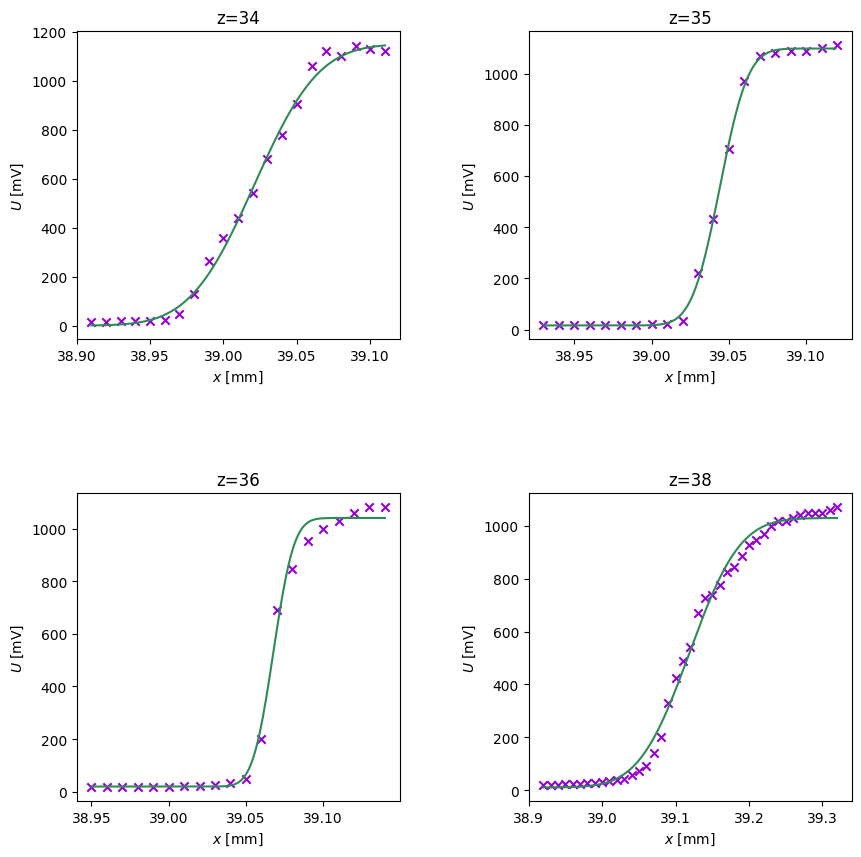

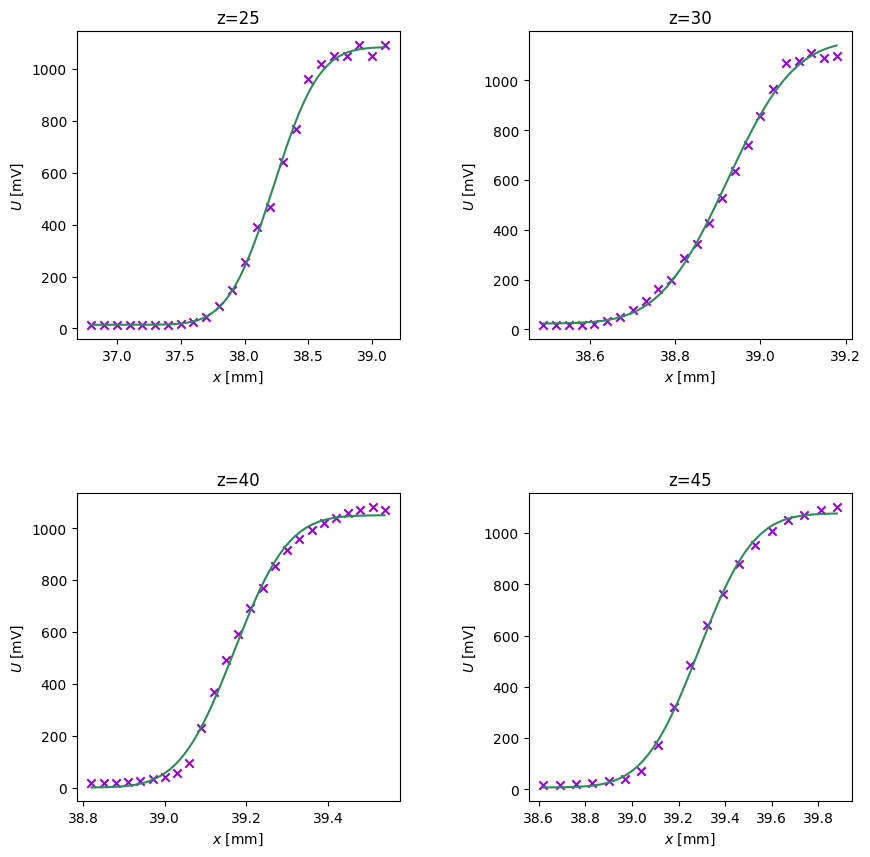

In [147]:
graf1_z = [[34, 35], [36, 38]]
graf2_z = [[25, 30], [40, 45]]

fig1, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for i, row in enumerate(graf1_z):
    for j, z in enumerate(row):
        parametry = vysledky_fitu[z]
        data=namerene_hodnoty[z]
        x_axis=np.arange(data["x[mm]"].min(), data["x[mm]"].max(), step=0.001)
        ax[i,j].scatter(x=data["x[mm]"], y=data["U[mV]"], 
                         color="darkviolet", marker="x")
        ax[i,j].plot(x_axis, metoda_ostre_hrany(x_axis, parametry["x_0"][0], parametry["w"][0], 
                                                 parametry["P_0"][0], parametry["P_max"][0]),
                                            color="seagreen")
        ax[i,j].set_title(f"z={z}")
        ax[i,j].set_xlabel("$x$ [mm]")
        ax[i,j].set_ylabel("$U$ [mV]")

fig1.savefig("./img/graf1.pdf")

fig2, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
for i, row in enumerate(graf2_z):
    for j, z in enumerate(row):
        parametry = vysledky_fitu[z]
        data=namerene_hodnoty[z]
        x_axis=np.arange(data["x[mm]"].min(), data["x[mm]"].max(), step=0.001)
        ax[i,j].scatter(x=data["x[mm]"], y=data["U[mV]"], 
                         color="darkviolet", marker="x")
        ax[i,j].plot(x_axis, metoda_ostre_hrany(x_axis, parametry["x_0"][0], parametry["w"][0], 
                                                 parametry["P_0"][0], parametry["P_max"][0]),
                                            color="seagreen")
        ax[i,j].set_title(f"z={z}")
        ax[i,j].set_xlabel("$x$ [mm]")
        ax[i,j].set_ylabel("$U$ [mV]")

fig2.savefig("./img/graf2.pdf")

w_0: (0.01\pm 0.03)


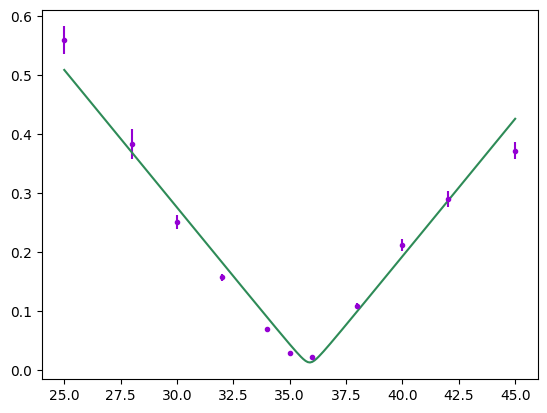

In [ ]:
z = [25, 28, 30, 32, 34, 35, 36, 38, 40, 42, 45]

w_0 = 0.013
z_0 = 0.22
z_1 = 35

fitovane_parametry, kovariance_parametru = optimize.curve_fit(polomer_svazku, 
                                                                    xdata=z, 
                                                                    ydata=sirka_svazku,
                                                                    p0=[w_0, z_0, z_1])
sigma_parametru = np.sqrt(np.diag(kovariance_parametru)) # tohle vypocita presnost, s jakou byly parametry urceny
zaokrouhlene_parametry = []
for j in range(len(fitovane_parametry)): # zaokrouhleni na jednu platnou cifru
    zaokrouhlene_parametry.append(zaokrouhleni(fitovane_parametry[j], 
                                                        reference=sigma_parametru[j]))

z_axis=np.arange(25, 45.1, 0.1)
plt.errorbar(x=z, y=sirka_svazku, yerr=sirka_svazku_err, fmt=".", color="darkviolet")
plt.plot(z_axis, polomer_svazku(z_axis, fitovane_parametry[0], fitovane_parametry[1], fitovane_parametry[2]),
         color="seagreen")

In [161]:
w_0=ufloat(fitovane_parametry[0], sigma_parametru[0])
z_0=ufloat(fitovane_parametry[1], sigma_parametru[1])

theta_0 = (w_0/z_0)*180/math.pi

lam=633*10**(-6)
M=w_0*theta_0*math.pi / lam

print(f"\\w_0=({w_0})")
print(f"\\z_0=({z_0})")
print(f"\\theta_0=({theta_0})")
print(f"\\M^2=({M})")

\theta_0=(3+/-10)
\M=((0.2+/-1.0)e+03)
